In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
def show_tensor_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
    MNIST('data/', download=True, transform=transform),
    batch_size=128,
    shuffle=True,
    drop_last=True)

Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 468


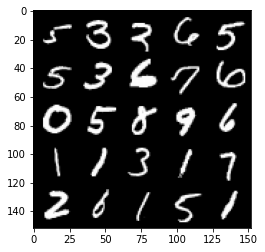

In [4]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(train_loader))

show_tensor_images(images)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 100
        self.n_out = 784
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(negative_slope=0.2, inplace=False)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(negative_slope=0.2, inplace=False)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(negative_slope=0.2, inplace=False)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(negative_slope=0.2, inplace=False),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(negative_slope=0.2, inplace=False),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(negative_slope=0.2, inplace=False),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G = Generator().to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

G = G.apply(weights_init)
D = D.apply(weights_init)

In [8]:
beta_1 =   0.5    
beta_2 =   0.999   
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(beta_1, beta_2))
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(beta_1, beta_2))

def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.ones_like(disc_pred))
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.zeros_like(disc_pred))
    return loss


In [9]:
display_step = 1000 

epochs = 100
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

D_losses = []
G_losses = []

Label Smoothing

In [10]:
def realloss(disc_pred, smooth=False):
    batch_size = disc_pred.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, labels)
    return loss

def fakeloss(disc_pred):
    batch_size = disc_pred.size(0)
    labels = torch.zeros(batch_size)
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, labels)
    return loss



  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.6753228777945051, discriminator loss: 0.6970440121889117


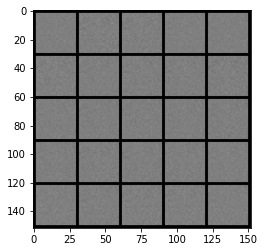

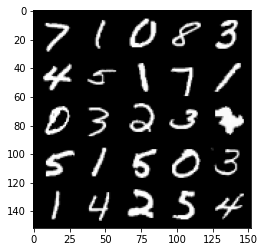

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.6931313902735723, discriminator loss: 0.6931551588177678


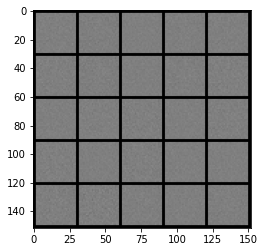

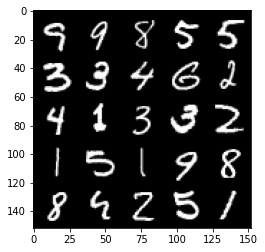

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.6931422997713103, discriminator loss: 0.6931496294736863


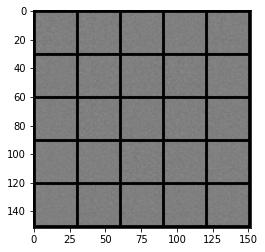

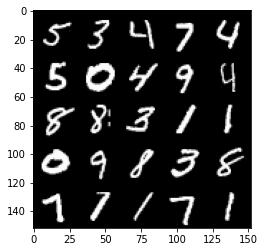

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.693145234882831, discriminator loss: 0.693148157179357


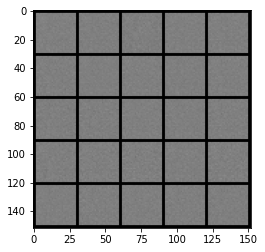

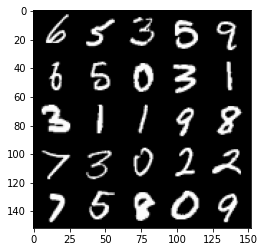

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.6931462683081622, discriminator loss: 0.693147635638715


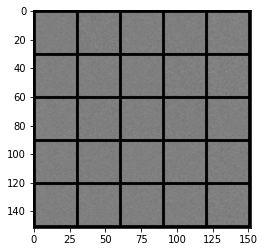

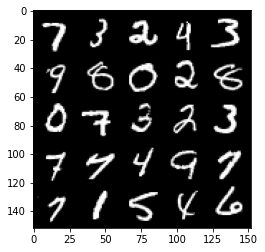

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.693146710872642, discriminator loss: 0.6931474197506942


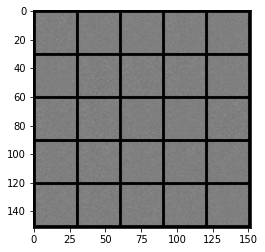

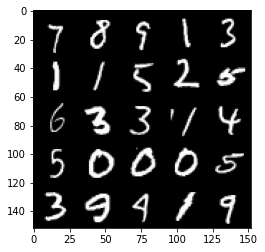

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.6931469288468327, discriminator loss: 0.6931473111510413


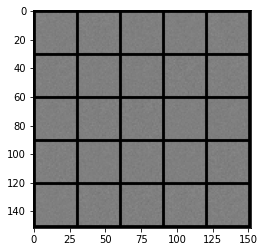

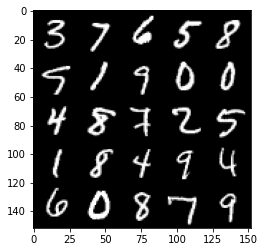

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.6931470514535826, discriminator loss: 0.6931472564339717


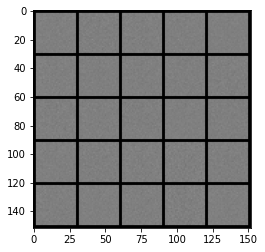

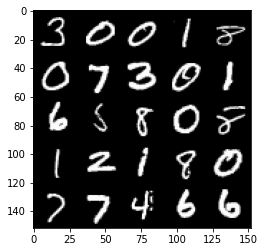

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.6931471297144896, discriminator loss: 0.6931472194194829


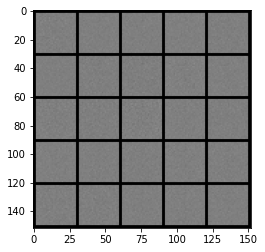

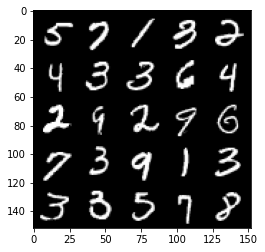

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.6931471812725105, discriminator loss: 0.6931471838951149


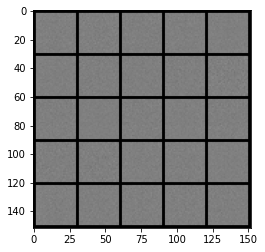

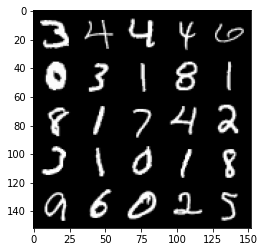

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


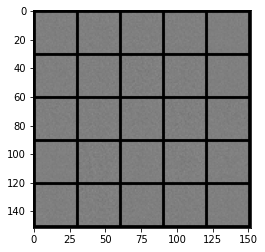

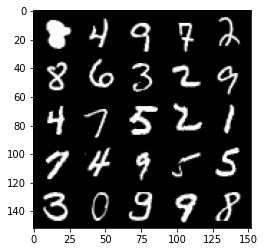

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


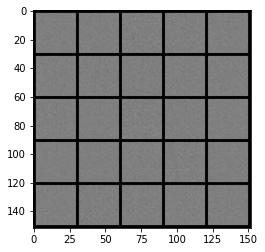

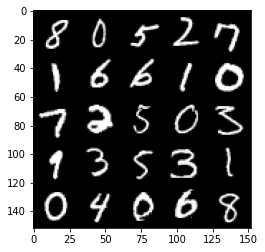

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


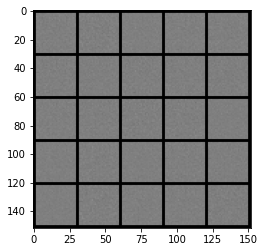

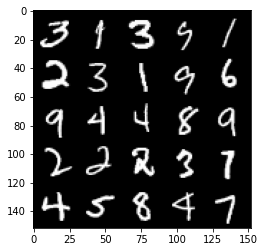

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


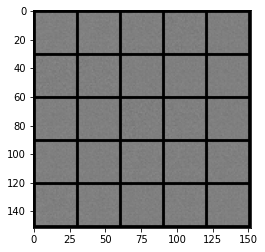

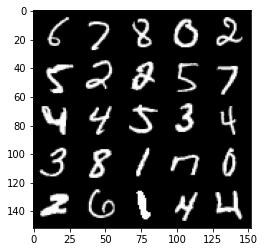

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


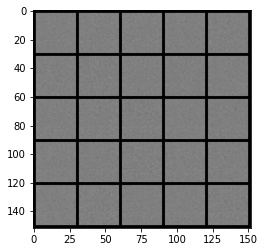

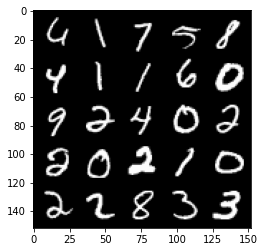

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


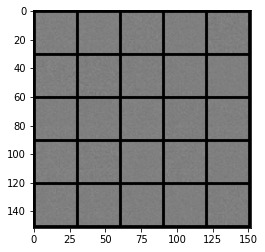

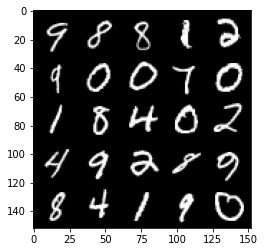

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


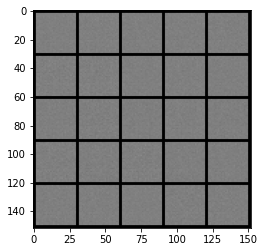

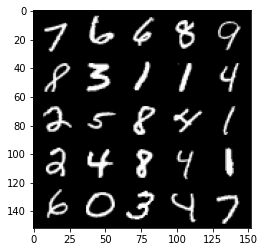

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


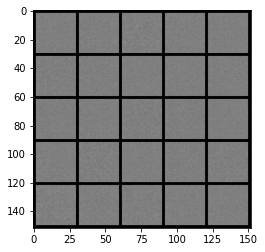

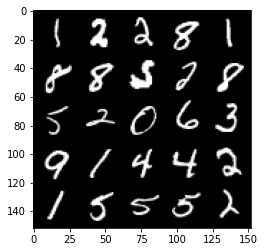

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


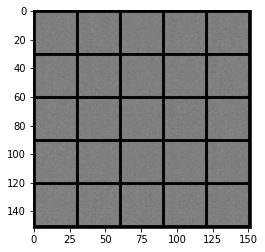

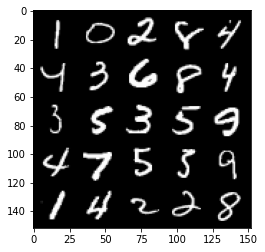

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


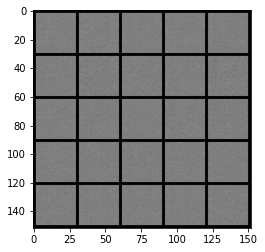

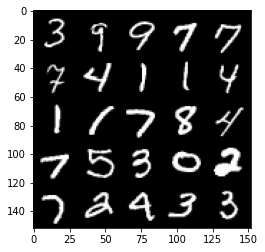

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


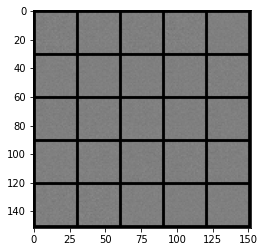

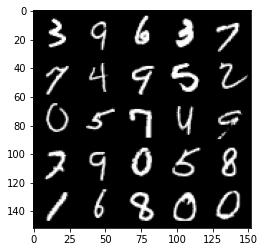

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


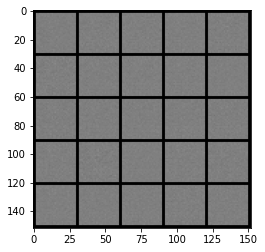

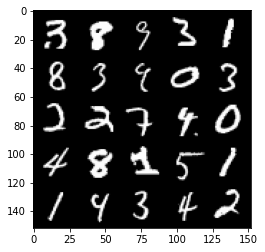

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


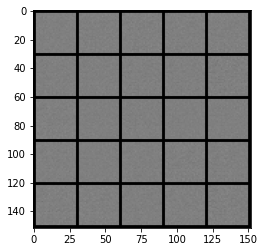

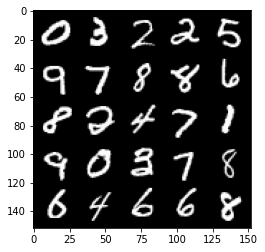

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 24000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


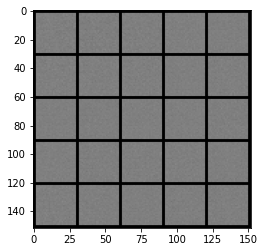

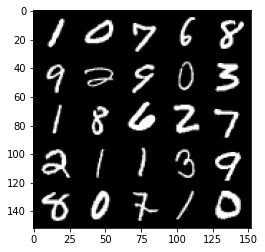

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 25000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


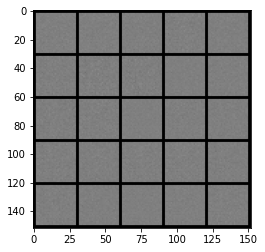

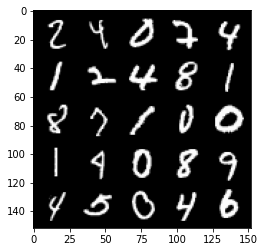

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 26000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


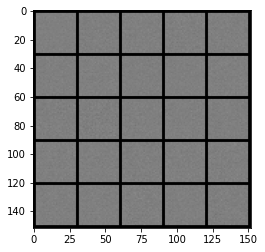

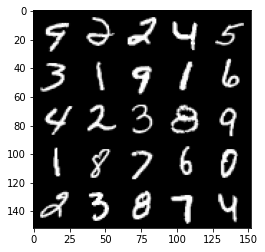

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 27000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


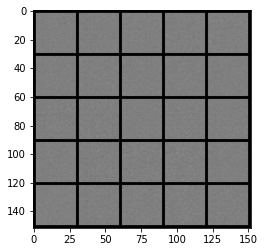

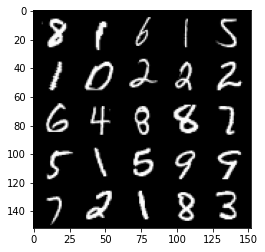

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 28000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


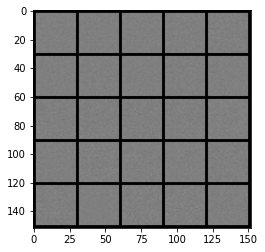

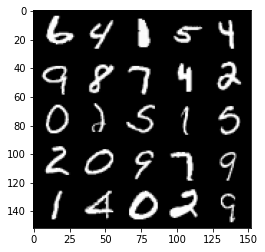

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 29000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


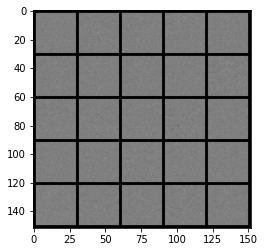

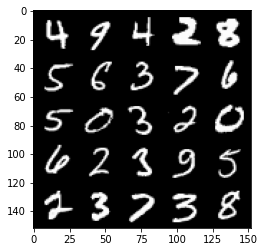

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 30000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


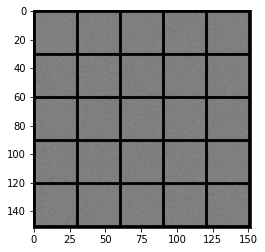

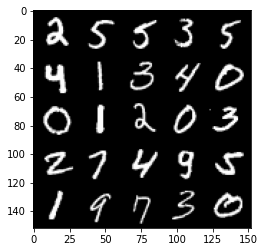

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 31000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


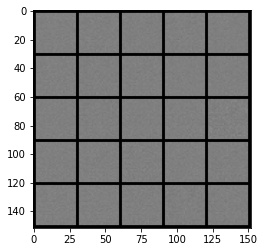

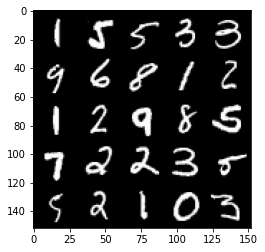

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 32000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


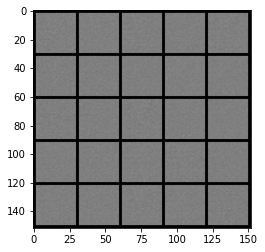

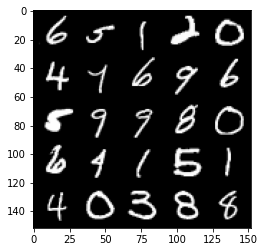

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 33000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


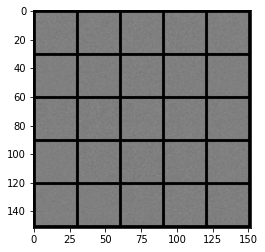

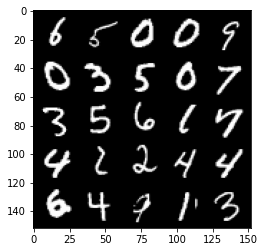

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 34000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


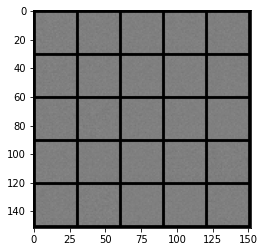

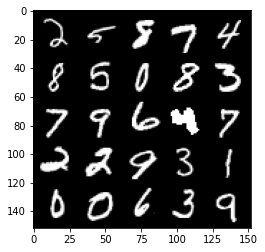

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 35000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


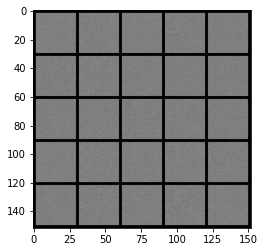

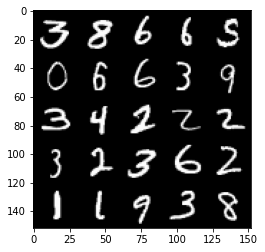

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 36000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


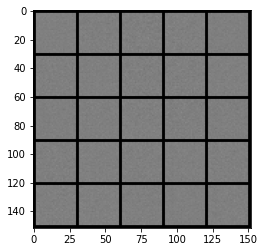

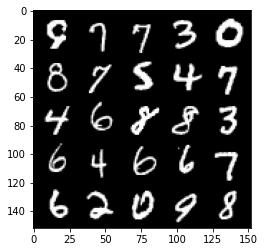

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 37000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


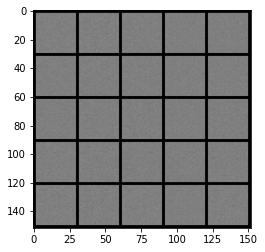

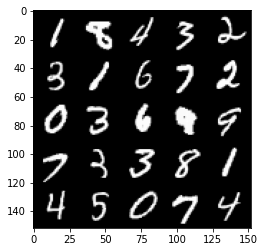

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 38000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


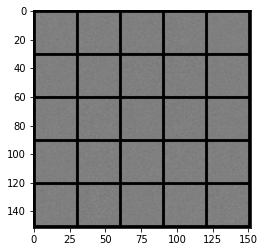

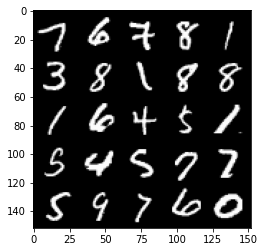

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 39000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


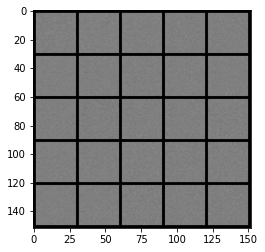

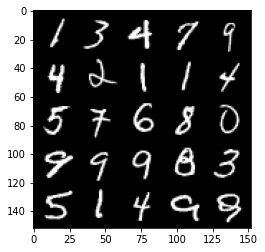

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 40000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


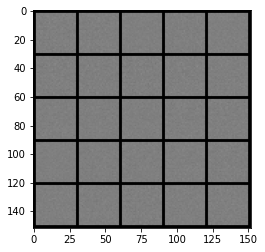

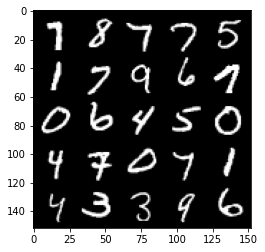

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 41000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


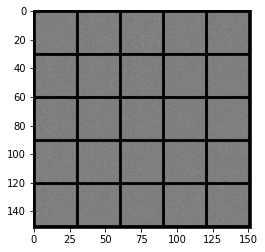

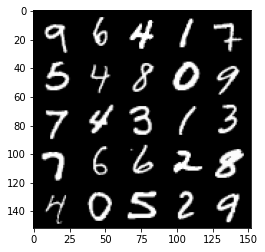

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 42000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


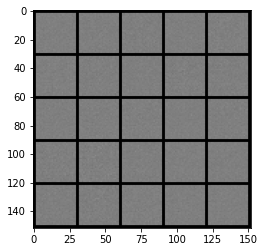

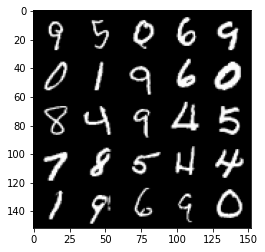

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 43000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


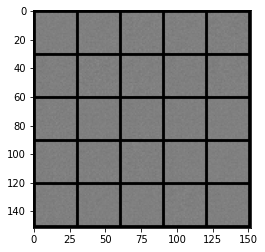

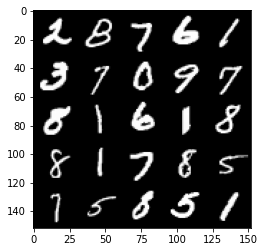

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 44000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


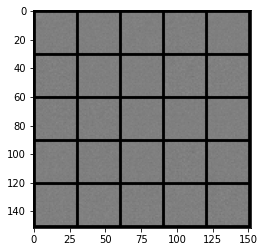

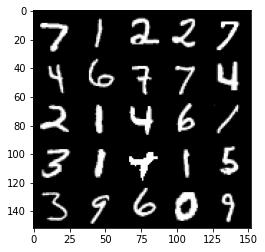

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 45000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


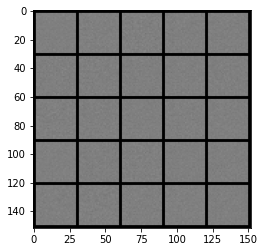

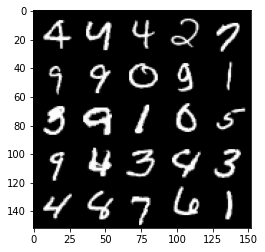

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Step 46000: Generator loss: 0.6931471824646035, discriminator loss: 0.6931471824646035


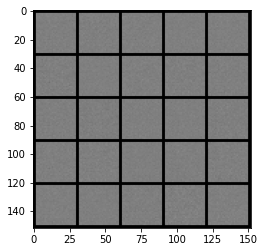

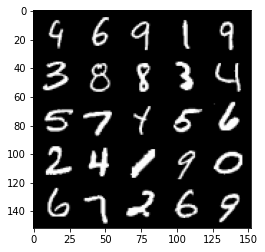

  0%|          | 0/468 [00:00<?, ?it/s]

In [11]:
for epoch in range(epochs):
    for real_img,_ in tqdm(train_loader):

        batch_size = real_img.size(0)
        real_img = real_img.to(device)

        D_opt.zero_grad()

        noise = torch.randn(batch_size, 100, device=device)
        fake_img = G(noise).detach()
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)
        D_loss = (D_real_loss+D_fake_loss)/2
        mean_discriminator_loss += D_loss.item() / display_step

        D_loss.backward(retain_graph=True)
        D_opt.step()
        
        G_opt.zero_grad()
        
        noise =  torch.randn(batch_size, 100, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)
        mean_generator_loss += G_loss.item() / display_step 

        G_loss.backward()
        G_opt.step()

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake_img)
            show_tensor_images(real_img)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


### Loss Vs Epochs

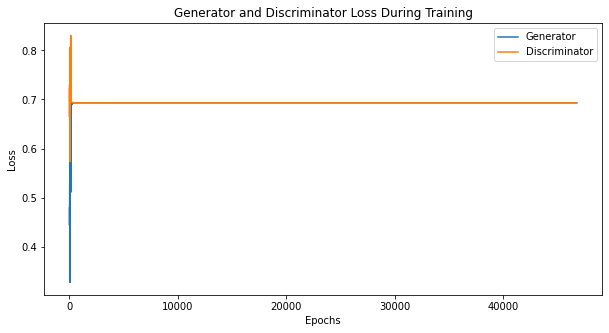

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###  10 x 10 grid plot of 100 randomly generated images

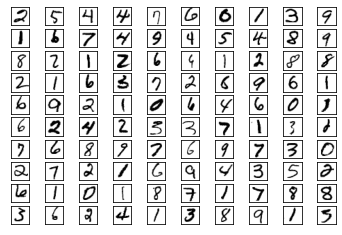

In [13]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])